# LUNA DB Run Overview

This notebook reads the local SQLite database (`data/luna.sqlite`), prints a compact run report, and plots temperature/humidity for each run.

In [1]:
from pathlib import Path
import sqlite3
from datetime import datetime

import matplotlib.pyplot as plt

DB_PATH = Path('../data/luna.sqlite')
if not DB_PATH.exists():
    raise FileNotFoundError(f'Database not found: {DB_PATH.resolve()}')

conn = sqlite3.connect(DB_PATH)
conn.row_factory = sqlite3.Row
print('Using DB:', DB_PATH.resolve())

Using DB: /Users/jorgbesier/dev/Curaluna/LUNA-device-detector/data/luna.sqlite


In [2]:
summary_sql = '''
SELECT
  r.run_id,
  r.file_name,
  r.start_ts,
  r.end_ts,
  r.sampling_interval_s,
  COUNT(rd.reading_id) AS reading_count,
  MIN(rd.temp_c) AS min_temp_c,
  MAX(rd.temp_c) AS max_temp_c,
  MIN(rd.rh_pct) AS min_rh_pct,
  MAX(rd.rh_pct) AS max_rh_pct
FROM runs r
LEFT JOIN readings rd ON rd.run_id = r.run_id
GROUP BY r.run_id
ORDER BY r.run_id
'''

rows = conn.execute(summary_sql).fetchall()

print('Run Summary')
print('-' * 120)
print(f"{'run_id':<7} {'readings':<9} {'sampling_s':<11} {'temp(min,max)':<20} {'rh(min,max)':<18} file")
print('-' * 120)
for r in rows:
    print(
        f"{r['run_id']:<7} {r['reading_count']:<9} {r['sampling_interval_s']:<11.3f} "
        f"({r['min_temp_c']:.1f},{r['max_temp_c']:.1f}){'':<8} ({r['min_rh_pct']:.1f},{r['max_rh_pct']:.1f}){'':<6} {r['file_name']}"
    )

Run Summary
------------------------------------------------------------------------------------------------------------------------
run_id  readings  sampling_s  temp(min,max)        rh(min,max)        file
------------------------------------------------------------------------------------------------------------------------
1       169       10.964      (25.2,29.1)         (68.0,81.0)       2026-02-03 13-37-48.log
2       504       10.664      (24.2,31.2)         (39.0,93.0)       2026-02-02 11-04-31 USB Single Serial #2 (1).log
3       3985      21.114      (16.5,24.8)         (53.0,95.0)       2026-02-05_09-18-19.log


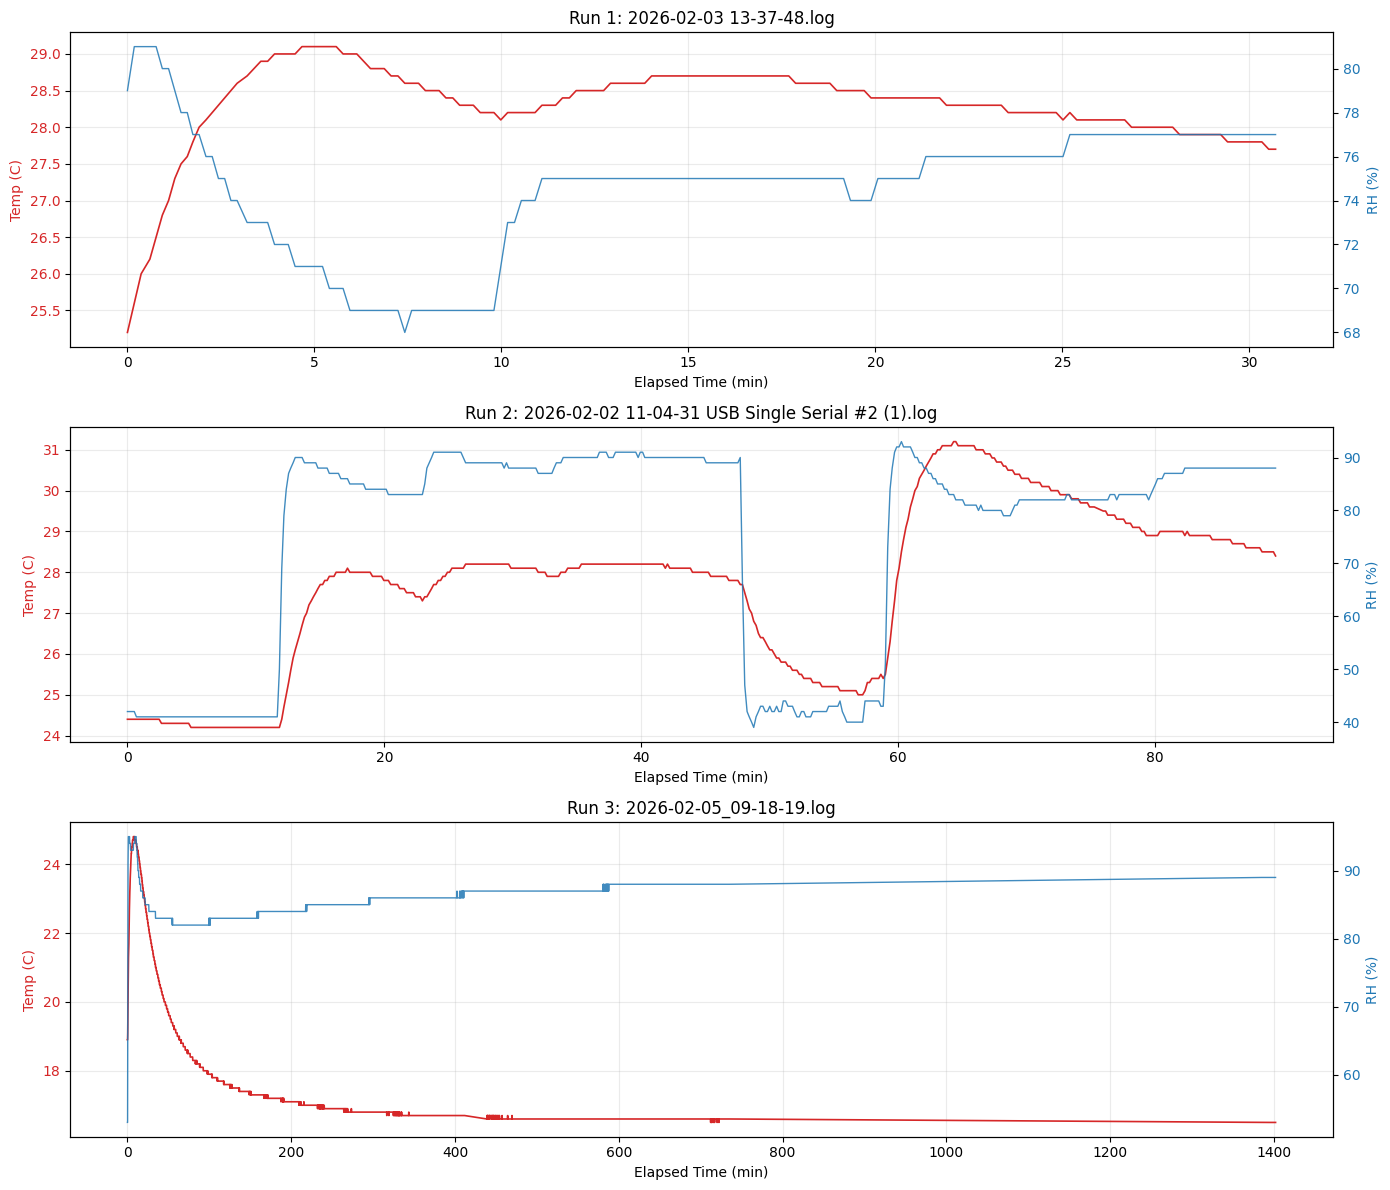

In [3]:
run_ids = [r['run_id'] for r in rows]
fig, axes = plt.subplots(len(run_ids), 1, figsize=(14, 4 * max(1, len(run_ids))), sharex=False)
if len(run_ids) == 1:
    axes = [axes]

for ax, run_id in zip(axes, run_ids):
    data = conn.execute(
        'SELECT t_elapsed_s, temp_c, rh_pct FROM readings WHERE run_id = ? ORDER BY t_elapsed_s',
        (run_id,),
    ).fetchall()

    t = [d['t_elapsed_s'] / 60.0 for d in data]  # minutes
    temp = [d['temp_c'] for d in data]
    rh = [d['rh_pct'] for d in data]

    ax.plot(t, temp, color='tab:red', linewidth=1.2, label='Temp (C)')
    ax.set_ylabel('Temp (C)', color='tab:red')
    ax.tick_params(axis='y', labelcolor='tab:red')
    ax.set_xlabel('Elapsed Time (min)')
    ax.grid(alpha=0.25)

    ax2 = ax.twinx()
    ax2.plot(t, rh, color='tab:blue', linewidth=1.0, alpha=0.85, label='RH (%)')
    ax2.set_ylabel('RH (%)', color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    file_name = next(r['file_name'] for r in rows if r['run_id'] == run_id)
    ax.set_title(f'Run {run_id}: {file_name}')

plt.tight_layout()
plt.show()

In [4]:
registry_summary_sql = '''
SELECT
  COUNT(*) AS total_rows,
  SUM(CASE WHEN run_id IS NOT NULL THEN 1 ELSE 0 END) AS linked_rows,
  SUM(CASE WHEN run_id IS NULL THEN 1 ELSE 0 END) AS unlinked_rows
FROM run_registry
'''

status_sql = '''
SELECT COALESCE(status, '(null)') AS status, COUNT(*) AS n
FROM run_registry
GROUP BY status
ORDER BY n DESC, status
'''

summary = conn.execute(registry_summary_sql).fetchone()
print('Run Registry Summary')
print('-' * 80)
print(f"total_rows={summary['total_rows']}, linked_rows={summary['linked_rows']}, unlinked_rows={summary['unlinked_rows']}")
print('\nStatus Breakdown')
for row in conn.execute(status_sql).fetchall():
    print(f"{row['status']:<12} {row['n']}")

Run Registry Summary
--------------------------------------------------------------------------------
total_rows=24, linked_rows=2, unlinked_rows=22

Status Breakdown
Done         13
(null)       6
Backlog      4
Active       1


In [5]:
linkage_sql = '''
SELECT
  rr.external_run_id,
  rr.status,
  rr.log_file_ref,
  rr.run_id,
  r.file_name AS linked_file_name,
  r.external_run_id AS run_external_run_id
FROM run_registry rr
LEFT JOIN runs r ON r.run_id = rr.run_id
ORDER BY rr.external_run_id
'''

print('Registry-to-Run Linkage (first 20 rows)')
print('-' * 120)
rows_link = conn.execute(linkage_sql).fetchall()
for row in rows_link[:20]:
    print(
        f"{row['external_run_id']:<8} | {str(row['status']):<8} | "
        f"log='{str(row['log_file_ref'])}' | run_id={str(row['run_id'])} | linked_file='{str(row['linked_file_name'])}'"
    )

print('\nUnlinked rows with a non-empty log_file_ref (action candidates):')
print('-' * 120)
unlinked = [
    row for row in rows_link
    if row['run_id'] is None and row['log_file_ref'] is not None and str(row['log_file_ref']).strip() != ''
]
for row in unlinked[:20]:
    print(f"{row['external_run_id']:<8} | status={str(row['status']):<8} | log='{row['log_file_ref']}'")
print(f"total_unlinked_with_log={len(unlinked)}")

Registry-to-Run Linkage (first 20 rows)
------------------------------------------------------------------------------------------------------------------------
T00001   | Backlog  | log='None' | run_id=None | linked_file='None'
T00002   | Backlog  | log='None' | run_id=None | linked_file='None'
T00003   | Done     | log='2026-02-02 10-20-30 USB Single Serial #2.log' | run_id=None | linked_file='None'
T00004   | Done     | log='2026-02-02 11-04-31 USB Single Serial #2.log' | run_id=None | linked_file='None'
T00005   | Done     | log='2026-02-02 16-42-26 USB Single Serial.log' | run_id=None | linked_file='None'
T00006   | Done     | log='2026-02-02 17-35-46 USB Single Serial.log' | run_id=None | linked_file='None'
T00007   | Done     | log='2026-02-03 13-37-48.log' | run_id=1 | linked_file='2026-02-03 13-37-48.log'
T00008   | Done     | log='2026-02-03_15-42-43.log' | run_id=None | linked_file='None'
T00009   | Done     | log='2026-02-04_08-48-00.log' | run_id=None | linked_file='None'


In [6]:
print('Quick Report')
print('-' * 80)
for r in rows:
    start = datetime.fromisoformat(r['start_ts'])
    end = datetime.fromisoformat(r['end_ts'])
    duration_min = (end - start).total_seconds() / 60.0
    print(
        f"Run {r['run_id']}: duration={duration_min:.1f} min, readings={r['reading_count']}, "
        f"sampling~{r['sampling_interval_s']:.2f}s, temp_range=({r['min_temp_c']:.1f},{r['max_temp_c']:.1f}), "
        f"rh_range=({r['min_rh_pct']:.1f},{r['max_rh_pct']:.1f})"
    )

conn.close()

Quick Report
--------------------------------------------------------------------------------
Run 1: duration=30.7 min, readings=169, sampling~10.96s, temp_range=(25.2,29.1), rh_range=(68.0,81.0)
Run 2: duration=89.4 min, readings=504, sampling~10.66s, temp_range=(24.2,31.2), rh_range=(39.0,93.0)
Run 3: duration=1402.0 min, readings=3985, sampling~21.11s, temp_range=(16.5,24.8), rh_range=(53.0,95.0)
